# Credit Card Fraud Prediction with XGBoost
_**Using Gradient Boosted Trees to Predict Fraudulent Transactions**_

---

## Contents

1. [Background](#Background)
1. [Setup](#Setup)
1. [Data](#Data)
1. [Imbalanced data problem](#Imbalanced_data_problem)
1. [Host](#Host)
  1. [Evaluate](#Evaluate)

## Background



Identifying Credit Card Fraudulent transaction is crucial to the banking business to protect their customers from fraud. Identifying fraud transactions is not an easy task and it can consume a lot of auditors time to identify those transactions and it can delay the purchasing of whatever items the card holder wants to purchase.

In this notebook, I will demonstrate how to build an binary classification model to predict whether a specific credit card transaction is genuine of fraud. I will use Sagemaker's implementation of XGBoost algorithm.

---
## Machine Learning Process

<img src="pics/MLProcess.png">


## Decision Trees and XGBoost

<img src="pics/decision_trees2.png" width="700" height="700">
<img src="pics/decision_trees.png" width="700" height="700">


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:.3f}'.format
# pd.set_option('display.max_columns', 500)

---
## Data


The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

The dataset we use is publicly available at https://www.kaggle.com/mlg-ulb/creditcardfraud

The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on http://mlg.ulb.ac.be/BruFence and http://mlg.ulb.ac.be/ARTML

Please cite: Andrea Dal Pozzolo, Olivier Caelen, Reid A. Johnson and Gianluca Bontempi. Calibrating Probability with Undersampling for Unbalanced Classification. In Symposium on Computational Intelligence and Data Mining (CIDM), IEEE, 2015

In [4]:
!ls ../data

credit_filtered.csv gm_2008_region.csv  mnist_digits.csv
creditcard.csv      kc_house_data.csv   telecom_churn.csv


In [5]:
import pandas as pd

credit_df = pd.read_csv('../data/credit_filtered.csv')
credit_df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,amnt,tm
0,-1.360,-0.073,2.536,1.378,-0.338,0.462,0.240,0.099,0.364,0.091,...,0.278,-0.110,0.067,0.129,-0.189,0.134,-0.021,0,1.783,-0.995
1,1.192,0.266,0.166,0.448,0.060,-0.082,-0.079,0.085,-0.255,-0.167,...,-0.639,0.101,-0.340,0.167,0.126,-0.009,0.015,0,-0.270,-0.995
2,-1.358,-1.340,1.773,0.380,-0.503,1.800,0.791,0.248,-1.515,0.208,...,0.772,0.909,-0.689,-0.328,-0.139,-0.055,-0.060,0,4.984,-0.995
3,-0.966,-0.185,1.793,-0.863,-0.010,1.247,0.238,0.377,-1.387,-0.055,...,0.005,-0.190,-1.176,0.647,-0.222,0.063,0.061,0,1.418,-0.995
4,-1.158,0.878,1.549,0.403,-0.407,0.096,0.593,-0.271,0.818,0.753,...,0.798,-0.137,0.141,-0.206,0.502,0.219,0.215,0,0.671,-0.995


# Exploratory Data Analysis

<img src="pics/MLProcess2.png" width="200" height="200">

### 1- Get The Dataframe Summary

Looks like the ```Time``` and ```Amount``` features need scaling

In [6]:
# Summarize the credit_df dataframe after scaling
credit_df.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V22,V23,V24,V25,V26,V27,V28,Class,amnt,tm
count,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,...,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000
mean,0.230,0.033,0.079,-0.014,0.011,-0.018,0.014,0.065,-0.036,-0.051,...,0.004,-0.005,-0.001,-0.002,0.000,-0.001,0.005,0.002,0.706,0.118
std,1.473,1.101,1.374,1.360,1.090,1.199,0.900,0.703,1.012,0.863,...,0.690,0.315,0.601,0.492,0.479,0.253,0.161,0.043,1.997,0.558
min,-30.552,-8.402,-31.104,-5.601,-22.106,-6.406,-43.557,-41.044,-13.434,-24.588,...,-8.887,-19.254,-2.837,-4.782,-1.653,-7.263,-2.513,0.000,-0.307,-0.995
25%,-0.806,-0.573,-0.802,-0.835,-0.666,-0.760,-0.528,-0.193,-0.641,-0.529,...,-0.536,-0.159,-0.354,-0.315,-0.325,-0.068,-0.050,0.000,-0.228,-0.359
50%,0.141,0.060,0.218,-0.018,-0.052,-0.281,0.044,0.027,-0.060,-0.100,...,0.007,-0.013,0.040,0.013,-0.051,0.001,0.011,0.000,-0.007,-0.002
75%,1.356,0.766,1.047,0.721,0.592,0.357,0.556,0.321,0.567,0.407,...,0.522,0.138,0.435,0.344,0.238,0.084,0.073,0.000,0.728,0.641
max,2.455,22.058,4.188,12.115,11.095,7.479,6.398,20.007,5.451,6.615,...,8.362,5.466,4.023,2.792,3.517,3.052,2.618,1.000,29.398,1.035


### 2- Checking The Balance of The Data

Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

In [7]:
print('The number of Non-Frauds are: ' + str(credit_df['Class'].value_counts()[0]) + ' which is ', round(credit_df['Class'].value_counts()[0]/len(credit_df) * 100,2), '% of the dataset')
print('The number of Frauds are: ' + str(credit_df['Class'].value_counts()[1]) + ' which is ', round(credit_df['Class'].value_counts()[1]/len(credit_df) * 100,2), '% of the dataset')


The number of Non-Frauds are: 270651 which is  99.82 % of the dataset
The number of Frauds are: 492 which is  0.18 % of the dataset


#### Plot the Class Distribution

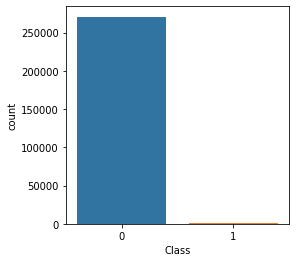

In [8]:
plt.figure(figsize=(4, 4))
sns.countplot('Class', data=credit_df);

### 3- Checking Missing Data

If there are any missing data in our dataset, we need to deal with them before training. Data Imputation is a critical step in the Feature Engineering phase.

In [9]:
credit_df.isna().sum().any()

False

### 3- Feature Correlation

A correlation matrix is a way to show the correlation between different variables in a dataset. Each cell in the table shows the correlation between two variables. A correlation matrix is used to summarize data and find what , as an input into a more advanced analysis

**Positive Correlation means:** As feature X increases, feature Y increases and vice versa.

**Negative Correlation means:** As feature X go in one direction (Increase), feature Y goes in the other direction (Decrease)

Let's plot the first correlation matrix for the imbalanced data.

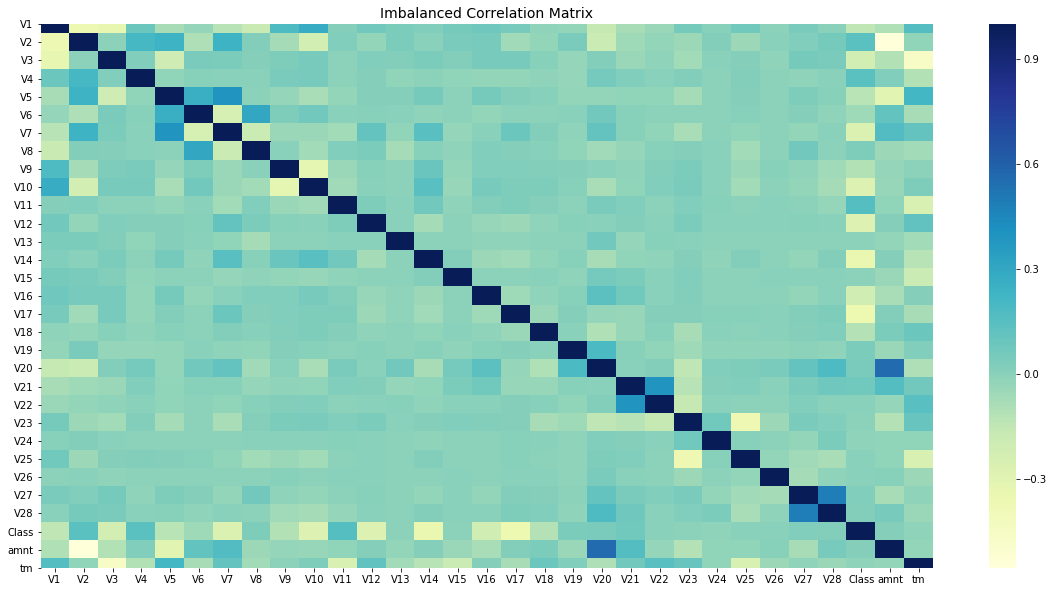

In [10]:
# Sample figsize in inches
fig, ax = plt.subplots(figsize=(20,10))         

# Imbalanced DataFrame Correlation
corr = credit_df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)

plt.show()

# Feature Engineering

1- Scale the features that needs scaling.

2- Detect and Remove Outliers.

3- Fix the target feature imbalance problem.

3- Split the data to train, validation and test.

<img src="pics/fengineering.png" width="200" height="200">

### 1- Fixing The Feature Scaling Problem For (Time and Amount)

In [141]:
# Since most of our data has already been scaled 
# we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import RobustScaler

# RobustScaler is robust to outliers.
credit_df['amount_after_scaling'] = RobustScaler().fit_transform(credit_df['Amount'].values.reshape(-1,1))
credit_df['time_after_scaling'] = RobustScaler().fit_transform(credit_df['Time'].values.reshape(-1,1))

In [21]:
credit_df.drop(['Time','Amount'], axis=1, inplace=True)

In [11]:
y = credit_df['Class']
X_all = credit_df.drop(['Class'], axis=1)

# Place the class in the begining of the dataframe
credit_df.drop(['Class'], axis=1, inplace=True)
credit_df.insert(0, 'Class', y)

In [12]:
credit_df.describe()

,Class,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,amnt,tm
count,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,...,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000,271143.000
mean,0.002,0.230,0.033,0.079,-0.014,0.011,-0.018,0.014,0.065,-0.036,...,-0.006,0.004,-0.005,-0.001,-0.002,0.000,-0.001,0.005,0.706,0.118
std,0.043,1.473,1.101,1.374,1.360,1.090,1.199,0.900,0.703,1.012,...,0.421,0.690,0.315,0.601,0.492,0.479,0.253,0.161,1.997,0.558
min,0.000,-30.552,-8.402,-31.104,-5.601,-22.106,-6.406,-43.557,-41.044,-13.434,...,-22.798,-8.887,-19.254,-2.837,-4.782,-1.653,-7.263,-2.513,-0.307,-0.995
25%,0.000,-0.806,-0.573,-0.802,-0.835,-0.666,-0.760,-0.528,-0.193,-0.641,...,-0.220,-0.536,-0.159,-0.354,-0.315,-0.325,-0.068,-0.050,-0.228,-0.359
50%,0.000,0.141,0.060,0.218,-0.018,-0.052,-0.281,0.044,0.027,-0.060,...,-0.028,0.007,-0.013,0.040,0.013,-0.051,0.001,0.011,-0.007,-0.002
75%,0.000,1.356,0.766,1.047,0.721,0.592,0.357,0.556,0.321,0.567,...,0.179,0.522,0.138,0.435,0.344,0.238,0.084,0.073,0.728,0.641
max,1.000,2.455,22.058,4.188,12.115,11.095,7.479,6.398,20.007,5.451,...,27.203,8.362,5.466,4.023,2.792,3.517,3.052,2.618,29.398,1.035


We can see immediately that:
- `time_after_scaling` appears to be quite evenly distributed and scaled with min and max values are within the range of the other features
- `amount_after_scaling` transaction amount values are also scaled to be within the range of the other features with min of -0.307 and max of 358.68

## Clear outliers (to be done...)

# Imbalanced_data_problem

https://towardsdatascience.com/methods-for-dealing-with-imbalanced-data-5b761be45a18

Always split into test and train sets BEFORE trying oversampling techniques! 

### Train-test split

In [13]:
y = credit_df['Class']
X_all = credit_df.drop(columns=['Class'])

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_all, y, stratify=y, random_state=1)

imbalanced_test_X, imbalanced_test_y = X_test, y_test

In [20]:
# no balancing

X_to_train = X_train.copy()
y_to_train = y_train.copy()

# roc_auc 0.927
# recall 0.854
# accuracy 1.000

# roc_auc 0.898
# recall 0.797
# accuracy 1.000

### 2- Fix the target feature imbalance problem (Resampling)

<img src="pics/resampling.png">

#### Undersampling The Class Feature

In [23]:
# Shuffle the Dataset.

Xy = X_train.copy()
Xy['Class'] = y

ones = Xy['Class'].value_counts().loc[1]
ones

369

In [24]:
# shuffle
shuffled_df = Xy.sample(frac=1,random_state=4)

# amount of fraud classes #ones rows.
fraud_df = shuffled_df.loc[shuffled_df['Class'] == 1]
#Randomly select #ones observations.
non_fraud_df = shuffled_df.loc[shuffled_df['Class'] == 0].sample(n=ones,random_state=42)


undersampled_df = pd.concat([fraud_df, non_fraud_df])

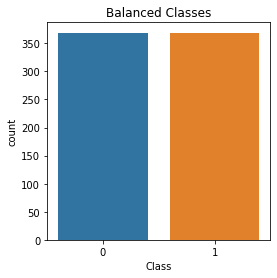

In [25]:
plt.figure(figsize=(4, 4))
sns.countplot('Class', data=undersampled_df)
plt.title('Balanced Classes')
plt.show()

In [26]:
y_to_train = undersampled_df['Class']
X_to_train = undersampled_df.drop(columns=['Class'])

# roc_auc 0.955
# recall 0.935
# accuracy 0.976

# roc_auc 0.934
# recall 0.894
# accuracy 0.973

## Simple oversampling

In [20]:
# Shuffle the Dataset.

Xy = X_train.copy()
Xy['Class'] = y

ones = Xy['Class'].value_counts().loc[1]
ones

369

In [21]:
from sklearn.utils import resample

#Randomly all majority class
non_fraud_df = Xy.loc[Xy['Class'] == 0]

# amount of fraud classes #ones rows.
fraud_df = Xy.loc[Xy['Class'] == 1]
# upsample minority
fraud_upsampled_df = resample(fraud_df,
                              replace=True, # sample with replacement
                              n_samples=len(non_fraud_df), # match number in majority class
                              random_state=27) # reproducible results


oversampled_df = pd.concat([fraud_upsampled_df, non_fraud_df])

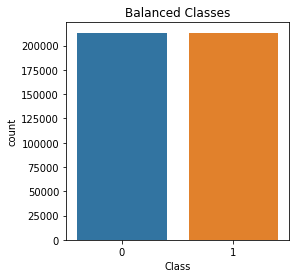

In [22]:
plt.figure(figsize=(4, 4))
sns.countplot('Class', data=oversampled_df)
plt.title('Balanced Classes')
plt.show()

In [23]:
y_to_train = oversampled_df['Class']
X_to_train = oversampled_df.drop(columns=['Class'])

# roc_auc 0.985
# recall 0.976
# accuracy 0.995

#### Oversampling The Class Feature with SMOTE

In [24]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(ratio='minority', random_state=7)

X_to_train, y_to_train = sm.fit_sample(X_train, y_train)
# oversampled_train = pd.concat([pd.DataFrame(oversampled_trainY), pd.DataFrame(oversampled_trainX)], axis=1)

X_to_train = pd.DataFrame(X_to_train, columns=X_train.columns)

In [25]:
smote_df = X_to_train.copy()
smote_df['Class'] = y_to_train

# roc_auc 0.954
# recall 0.919
# accuracy 0.989

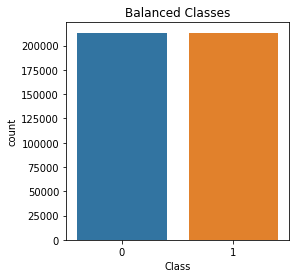

In [26]:
plt.figure(figsize=(4, 4))
sns.countplot('Class', data=smote_df)
plt.title('Balanced Classes')
plt.show()

## Train and evaluate

In [27]:
from xgboost import XGBClassifier

clf = XGBClassifier(random_state=1).fit(X_to_train, y_to_train)
y_pred = clf.predict(imbalanced_test_X)

In [28]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score

print("roc_auc %.3f" % roc_auc_score(imbalanced_test_y, y_pred))
print("recall %.3f" % recall_score(imbalanced_test_y, y_pred))
print("accuracy %.3f" % accuracy_score(imbalanced_test_y, y_pred))


roc_auc 0.934
recall 0.894
accuracy 0.973


In [ ]:
roc_auc 0.947
recall 0.919
accuracy 0.975

In [29]:
from sklearn.svm import SVC

In [30]:
X_to_train.shape

(738, 30)

In [31]:
sclf = SVC().fit(X_to_train, y_to_train)

/Users/nickkon/.local/share/virtualenvs/itea-intro-ds/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [32]:
y_pred = sclf.predict(imbalanced_test_X)

In [33]:
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score

print("roc_auc %.3f" % roc_auc_score(imbalanced_test_y, y_pred))
print("recall %.3f" % recall_score(imbalanced_test_y, y_pred))
print("accuracy %.3f" % accuracy_score(imbalanced_test_y, y_pred))

roc_auc 0.947
recall 0.919
accuracy 0.975


## Use specific algo that adresses the problem of imbalanced data

In [30]:
from imblearn.ensemble import BalancedBaggingClassifier 
from sklearn.tree import DecisionTreeClassifier

In [31]:
bbc = BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(),
                                sampling_strategy='auto',
                                replacement=False,
                                random_state=0)
bbc.fit(X_train, y_train)

BalancedBaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None,
                                                                criterion='gini',
                                                                max_depth=None,
                                                                max_features=None,
                                                                max_leaf_nodes=None,
                                                                min_impurity_decrease=0.0,
                                                                min_impurity_split=None,
                                                                min_samples_leaf=1,
                                                                min_samples_split=2,
                                                                min_weight_fraction_leaf=0.0,
                                                                presort=False,
                                                                r

In [32]:
y_pred = bbc.predict(imbalanced_test_X)
# roc_auc 0.948
# recall 0.919
# accuracy 0.977

### Conclusion
*dealing with imbalanced datasets:*
 - Change the performance metric
 - Change the algorithm
 - Oversample minority class
 - Undersample majority class
 - Generate synthetic samples

### Check The Correlation Matrix After Downsampling

In [ ]:
y_to_train = oversampled_df['Class']
X_to_train = oversampled_df.drop(columns=['Class'])

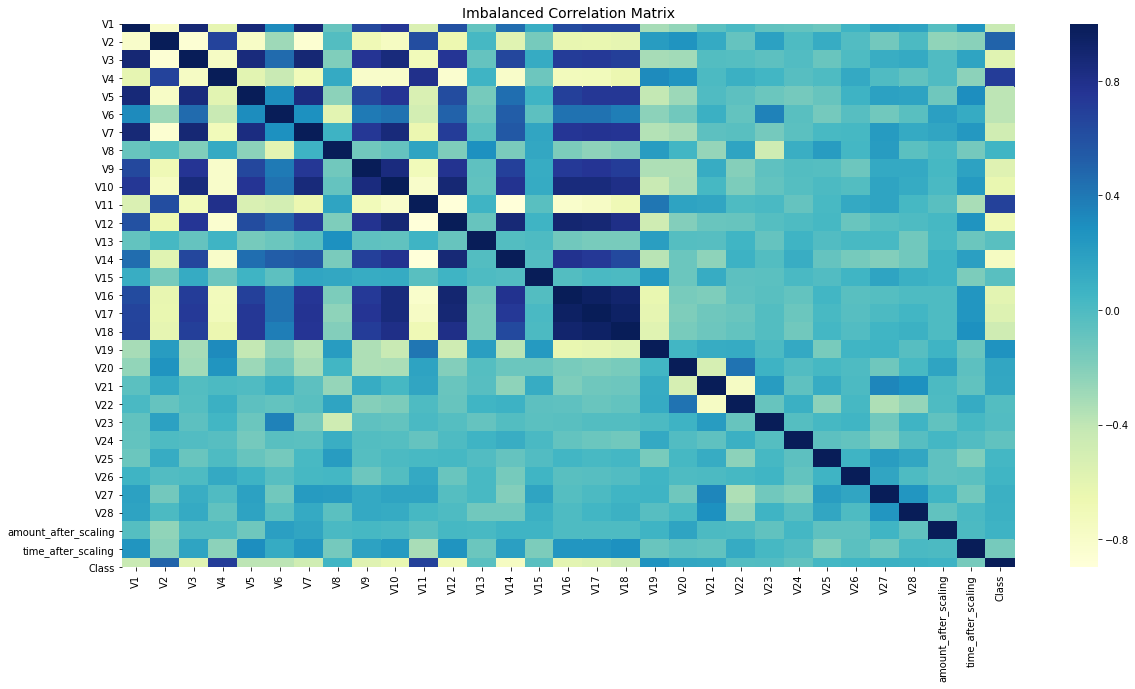

In [106]:
fig, ax = plt.subplots(figsize=(20,10))         

# Imbalanced DataFrame Correlation
corr = oversampled_df.corr()
sns.heatmap(corr, cmap='YlGnBu', annot_kws={'size':30}, ax=ax)
ax.set_title("Imbalanced Correlation Matrix", fontsize=14)

plt.show()

**Negative Correlations:** Some features, such as V17, V14, V12 are negatively correlated with the target class. That means that the lower these values, the more likely the transaction will be a fraudulent.

**Positive Correlations:** Features V2, V4, V11 are positively correlated. That means that the higher these values, the more likely the transaction will be a fraudulent.

Now, let's find any outliers in those features:

--------------------



In [110]:
# outliers detection

## Model Tuning:

<img src="pics/model_tuning.png" width="700" height="700">



### Tuning The Model - Hyperparameter Optimization (HPO)

Hyperparameter tuning is a supervised machine learning regression problem. Given a set of input features (the hyperparameters), hyperparameter tuning optimizes a model for the metric that you choose. hyperparameter tuning makes guesses about which hyperparameter combinations are likely to get the best results, and runs training jobs to test these guesses.

Now, we can specify a few parameters like what type of training instances we'd like to use and how many, as well as our XGBoost hyperparameters.  A few key hyperparameters are:
- `max_depth` controls how deep each tree within the algorithm can be built.  Deeper trees can lead to better fit, but are more computationally expensive and can lead to overfitting.  There is typically some trade-off in model performance that needs to be explored between a large number of shallow trees and a smaller number of deeper trees.
- `subsample` controls sampling of the training data.  This technique can help reduce overfitting, but setting it too low can also starve the model of data.
- `num_round` controls the number of boosting rounds.  This is essentially the subsequent models that are trained using the residuals of previous iterations.  Again, more rounds should produce a better fit on the training data, but can be computationally expensive or lead to overfitting.
- `eta` controls how aggressive each round of boosting is.  Larger values lead to more conservative boosting.
- `gamma` controls how aggressively trees are grown.  Larger values lead to more conservative models.

Binary classification error rate. It is calculated as #(wrong cases)/#(all cases)


More detail on XGBoost's hyperparmeters can be found on their GitHub [page](https://github.com/dmlc/xgboost/blob/master/doc/parameter.md).

In [111]:
xgb_clf = XGBClassifier(max_depth=10, objective='binary:logistic', num_round=100, seed=1)
# xgb_clf.fit(X_train, y_train)

In [113]:
from sklearn.model_selection import RandomizedSearchCV

In [114]:
params = {
    'eta': np.linspace(0,1,11),
    'min_child_weight': np.linspace(1,10,51),
    'alpha': np.linspace(0,2,21),
    'max_depth': np.arange(1,11,1),  
}

In [115]:
rcv = RandomizedSearchCV(estimator=xgb_clf,
                        param_distributions=params,
                        cv=3,
                        n_iter=1,
                        n_jobs=-2,
                        random_state=1,
                        scoring="roc_auc")

In [116]:
len(X_to_train)

426472

In [117]:
rcv.fit(X_to_train, y_to_train);

In [118]:
model = rcv.best_estimator_

In [119]:
type(model)

xgboost.sklearn.XGBClassifier

In [122]:
y_pred = model.predict(imbalanced_test_X)

In [123]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, recall_score, precision_score

print("roc_auc %.3f" % roc_auc_score(imbalanced_test_y, y_pred))
print("recall %.3f" % recall_score(imbalanced_test_y, y_pred))
print("accuracy %.3f" % accuracy_score(imbalanced_test_y, y_pred))

roc_auc 0.954
recall 0.919
accuracy 0.989


In [ ]:
# roc_auc 0.954
# recall 0.919
# accuracy 0.989

In [124]:
precision_score(imbalanced_test_y, y_pred)

0.125

## Save the weights of the model to the file


In [34]:
import pickle

In [36]:
filename = "./xgboost-model.pkl"

with open(filename, 'wb') as f:
    pickle.dump(clf, file=f)

## Unpack the model and test

In [37]:
transaction= "-1.009630,0.141192,0.167167,-0.808785,2.112167,-1.294934,0.592454,-0.049872,-0.284882,-1.296757,-1.010293,-0.272631,-0.139809,-0.918097,-0.475136,0.519497,0.158822,-0.120745,-0.519128,0.108956,-0.225473,-0.947079,0.054725,0.368866,-0.158482,0.070904,0.022035,0.177674,-0.279746,0.391123"
test = transaction.split(',')
data = np.asarray(test).reshape((1,-1))
data = data.astype(float)
test_matrix = pd.DataFrame(data, columns=X_to_train.columns)

In [38]:
with open(filename, 'rb') as f:
    xgb_loaded = pickle.load(f)
predictions = xgb_loaded.predict(test_matrix)
predictions[0]

0

## Interperting the Machine Learning Model

In [39]:
# !pip3 install graphviz

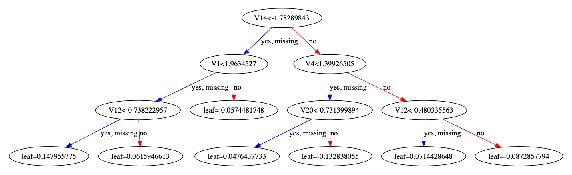

In [42]:
from xgboost import plot_tree, Booster
import xgboost as xgb
import matplotlib.pyplot as plt
import pickle as pkl
from xgboost import plot_tree, plot_importance
from matplotlib.pylab import rcParams

filename='./xgboost-model.pkl'
# plot single tree
rcParams['figure.figsize'] = 10,10
 
model = pkl.load(open(filename,'rb')) 
plot_tree(model, num_trees=4)
plt.show()


In [43]:
from xgboost import plot_importance

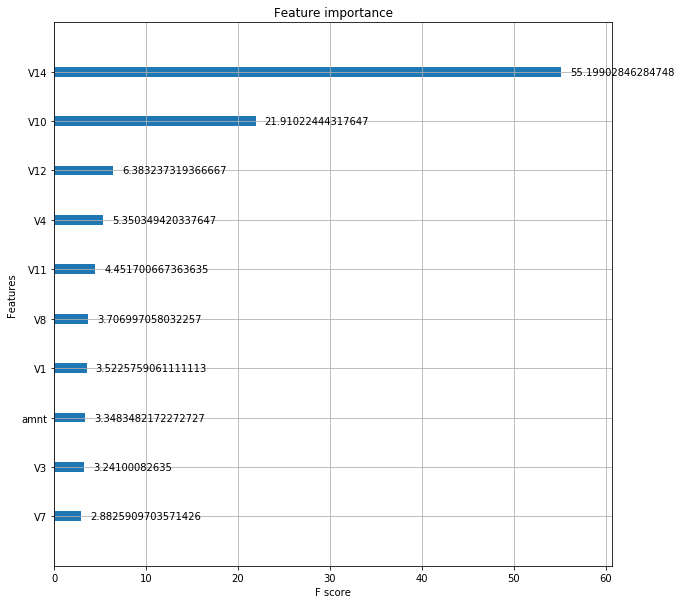

In [44]:
plot_importance(model, importance_type="gain", max_num_features=10);

In [72]:
plot_importance?

In [41]:
plot_tree?